In [60]:
import os
import re
import glob
from datetime import datetime
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
sys.path.append("..") # Adds higher directory to python modules path for importing from src dir

from src.algorithms import SimpleLSTM, MLPClassifier, SVC
from src.datasets import NyseStocksDataset
from src.evaluation import Evaluator, Plotter
from src.utils import print_metrics_as_md, pandas_df_to_markdown_table
# from src.pipeline import run_pipeline, prepare_data, evaluate_results
# from src.experiments import get_metrics

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 435 ms


In [2]:
plotter = Plotter('../reports')

time: 293 ms


# Experiments

## 1. Feature selection
- MLP & SimpleLSTM
- All-2C, All-3C, OC-3C, OHLC-3C, Open-3C

Winner: __OC-3C__

|  -   |     All-2C    MLP   |     All-2C    SLSTM_shuffle   |     All-3C    MLP   |     All-3C    SLSTM_shuffle   |     OC-3C    MLP   |     OC-3C    SLSTM_shuffle   |     OHLC-3C    MLP   |     OHLC-3C    SLSTM_shuffle   |     Open-3C    MLP   |     Open-3C    SLSTM_shuffle   |
|:-----|--------------------:|------------------------------:|--------------------:|------------------------------:|-------------------:|-----------------------------:|---------------------:|-------------------------------:|---------------------:|-------------------------------:|
| prec |           0.473675  |                     0.451195  |           0.330751  |                     0.298249  |          0.368896  |                    0.340891  |            0.320769  |                     0.33705    |           0.369802   |                      0.342179  |
| rec  |           0.4825    |                     0.451833  |           0.310833  |                     0.309333  |          0.344833  |                    0.340833  |            0.305     |                     0.336333   |           0.337      |                      0.3395    |
| f1   |           0.435161  |                     0.450036  |           0.308623  |                     0.297981  |          0.300402  |                    0.316042  |            0.287787  |                     0.314503   |           0.234739   |                      0.308558  |
| acc  |           0.4825    |                     0.451833  |           0.310833  |                     0.309333  |          0.344833  |                    0.340833  |            0.305     |                     0.336333   |           0.337      |                      0.3395    |
| mcc  |          -0.0429275 |                    -0.0969692 |          -0.0348393 |                    -0.0367314 |          0.0213947 |                    0.0120531 |           -0.0450657 |                     0.00477629 |           0.00990098 |                      0.0101475 |

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/feature-selection.csv")

## 2. Number of Classes
- MLP & SimpleLSTM & SimpleLSTMShuffle & SVC
- All-2C, All-3C, OC-2C, OC-3C

Winner: __OC-3C__


| -  |   datasets    predictors     |     All-2C    MLP   |     All-2C    SLSTM   |     All-2C    SLSTM_shuffle   |     All-2C    SVC   |     All-3C    MLP   |     All-3C    SLSTM   |     All-3C    SLSTM_shuffle   |     All-3C    SVC   |     OC-2C    MLP   |     OC-2C    SLSTM   |     OC-2C    SLSTM_shuffle   |     OC-2C    SVC   |     OC-3C    MLP   |     OC-3C    SLSTM   |     OC-3C    SLSTM_shuffle   |     OC-3C    SVC   |
|---:|:-----------------------------|--------------------:|----------------------:|------------------------------:|--------------------:|--------------------:|----------------------:|------------------------------:|--------------------:|-------------------:|---------------------:|-----------------------------:|-------------------:|-------------------:|---------------------:|-----------------------------:|-------------------:|
|  0 | prec                         |             0.47367 |               0.25    |                       0.46111 |             0.46438 |             0.33075 |               0.11111 |                       0.30102 |             0.3193  |            0.50449 |              0.25    |                      0.50802 |            0.49017 |            0.3689  |              0.11111 |                      0.34566 |            0.34713 |
|  1 | rec                          |             0.4825  |               0.5     |                       0.466   |             0.46883 |             0.31083 |               0.33333 |                       0.31167 |             0.33267 |            0.502   |              0.5     |                      0.508   |            0.49017 |            0.34483 |              0.33333 |                      0.33467 |            0.34733 |
|  2 | f1                           |             0.43516 |               0.33333 |                       0.44866 |             0.45169 |             0.30862 |               0.16667 |                       0.29172 |             0.31268 |            0.42185 |              0.33333 |                      0.50775 |            0.49017 |            0.3004  |              0.16667 |                      0.28432 |            0.33982 |
|  3 | acc                          |             0.4825  |               0.5     |                       0.466   |             0.46883 |             0.31083 |               0.33333 |                       0.31167 |             0.33267 |            0.502   |              0.5     |                      0.508   |            0.49017 |            0.34483 |              0.33333 |                      0.33467 |            0.34733 |
|  4 | mcc                          |            -0.04293 |               0       |                      -0.07273 |            -0.06664 |            -0.03484 |               0       |                      -0.03433 |            -0.00104 |            0.00599 |              0       |                      0.01602 |           -0.01967 |            0.02139 |              0       |                      0.00225 |            0.02146 |


[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/classes-2vs3.csv")

## 3. Test on Many Samples

- MLP & SimpleLSTMShuffle
- All-3C, OC-3C
- Samples: 600k

Winner: __All-3C, MLP__

When training with more samples it's useful to provide more features.
Still wondering why LSTM isn't better than MLP - might be because LSTM didn't converge (see history plots). The val_acc didn't improve until 20th epoch and afterwards started oszillation intensively (with an increasing mean).

| -  |   datasets    predictors     |     All-3C    MLP   |     All-3C    SLSTM_shuffle   |     OC-3C    MLP   |     OC-3C    SLSTM_shuffle   |
|---:|:-----------------------------|--------------------:|------------------------------:|-------------------:|-----------------------------:|
|  0 | prec                         |             0.39888 |                       0.37705 |            0.36527 |                      0.38532 |
|  1 | rec                          |             0.40535 |                       0.35013 |            0.36832 |                      0.35853 |
|  2 | f1                           |             0.39455 |                       0.29944 |            0.33878 |                      0.30229 |
|  3 | acc                          |             0.40535 |                       0.35013 |            0.36832 |                      0.35853 |
|  4 | mcc                          |             0.10996 |                       0.03225 |            0.05683 |                      0.04865 |

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/600k-samples.csv")

## 4. Why does not Shuffling Fail for LSTM?

- SimpleLSTM & SimpleLSTMShuffle
- OC-3C

1st Run: learning rate=0.1

| -  |   datasets    predictors     |     OC-3C    SLSTM   |     OC-3C    SLSTM_shuffle   |
|---:|:-----------------------------|---------------------:|-----------------------------:|
|  0 | prec                         |              0.11111 |                      0.2377  |
|  1 | rec                          |              0.33333 |                      0.34017 |
|  2 | f1                           |              0.16667 |                      0.23521 |
|  3 | acc                          |              0.33333 |                      0.34017 |
|  4 | mcc                          |              0       |                      0.01705 |

2nd Run: learning rate=0.01

| -  |   datasets    predictors     |     OC-3C    SLSTM   |     OC-3C    SLSTM_shuffle   |
|---:|:-----------------------------|---------------------:|-----------------------------:|
|  0 | prec                         |              0.11111 |                      0.30789 |
|  1 | rec                          |              0.33333 |                      0.32    |
|  2 | f1                           |              0.16667 |                      0.26147 |
|  3 | acc                          |              0.33333 |                      0.32    |
|  4 | mcc                          |              0       |                     -0.0231  |

Winner: __SLSTM_shuffle[lr=0.1]__

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/shuffling.csv")
[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/shuffling.csv-1")

## 5. Good batch sizes for SLSTM

- SimpleLSTM [bs = 16 - 512]
- OC-3C, All-3C

The history of the approaches showed dann a very high batch size leeds to a saver convergence. But it's only converging for train and val data. Test set remains bad. I guess, the models with high batch size are more stable but also totally overfit.

|   -    |   datasets    predictors     |     OC-3C    SLSTM_bs16   |     OC-3C    SLSTM_bs32   |     OC-3C    SLSTM_bs64   |     OC-3C    SLSTM_bs128   |     OC-3C    SLSTM_bs256   |
|:-------|:-----------------------------|--------------------------:|--------------------------:|--------------------------:|---------------------------:|---------------------------:|
| 0      | prec                         |                   0.36755 |                   0.3343  |                   0.35211 |                    0.35629 |                    0.3551  |
| 1      | rec                          |                   0.34544 |                   0.34344 |                   0.358   |                    0.35622 |                    0.35667 |
| 2      | f1                           |                   0.24508 |                   0.24422 |                   0.32332 |                    0.3493  |                    0.34756 |
| 3      | acc                          |                   0.34544 |                   0.34344 |                   0.358   |                    0.35622 |                    0.35667 |
| 4      | mcc                          |                   0.028   |                   0.02431 |                   0.04044 |                    0.03506 |                    0.03575 |
| bs     | 0                            |                  16       |                  32       |                  64       |                  256       |                  512       |
| epochs | 0                            |                  50       |                 100       |                 150       |                  200       |                  250       |


Winner: __SLSTM_bs64__

[comment]: <> (Execution Code: custom_print_md)

In [66]:
def custom_print_md():
    df = pd.read_csv("../reports/custom/lstm-batch-size-val-shuffled-lr001.csv", header=[0, 1])
    # df.loc['bs'] = int(re.search(r'[0-9]+$', x).group(0)
    df.loc['bs'] = [0, 256, 16, 512, 32, 64]
    df.loc['epochs'] = [0, 200, 50, 250, 100, 150]
    df.sort_values(axis=1, by='bs', inplace=True)
    print(pandas_df_to_markdown_table(df))
# custom_print_md()

time: 363 ms


### 6. Many Epochs

- SimpleLSTM [bs = 64 - 512] with 500 epochs
- 90k/9k from OC-3C

| -  |   datasets    predictors     |     OC-3C    SLSTM_bs64   |     OC-3C    SLSTM_bs256   |     OC-3C    SLSTM_bs512   |
|:---|:-----------------------------|--------------------------:|---------------------------:|---------------------------:|
| 0  | prec                         |                   0.23335 |                    0.34228 |                    0.34124 |
| 1  | rec                          |                   0.34089 |                    0.34444 |                    0.34256 |
| 2  | f1                           |                   0.22251 |                    0.34098 |                    0.3359  |
| 3  | acc                          |                   0.34089 |                    0.34444 |                    0.34256 |
| 4  | mcc                          |                   0.02126 |                    0.01678 |                    0.01407 |
| bs | 0                            |                  64       |                  256       |                  512       |

Winner: __SLSTM_bs64[epochs=500, lr=0.01]__

Outcome: Validation set is not good selected (models overfit)

[comment]: <> (Execution Code: custom_print_md)

In [71]:
def custom_print_md():
    df = pd.read_csv("../reports/custom/lstm-many-epochs.csv", header=[0, 1])
    # df.loc['bs'] = int(re.search(r'[0-9]+$', x).group(0)
    df.loc['bs'] = [0, 256, 512, 64]
    df.sort_values(axis=1, by='bs', inplace=True)
    print(pandas_df_to_markdown_table(df))
# custom_print_md()

time: 237 ms


### Good epsilon for `still` class

- SimpleLSTM_bs64, SimpleLSTM_bs512 with 200 epochs
- OC-3C[epsilon=0.01], OC-3C[epsilon=0.007], OC-3C[epsilon=0.004], OC-3C[epsilon=0.0005], OC-3C[epsilon=0.0005]

Failed after first 0.0005 run (classes were not even distributed)

| -  |   datasets    predictors     |     OC-3C-e01    SLSTM_bs64   |     OC-3C-e01    SLSTM_bs512   |     OC-3C-e007    SLSTM_bs64   |     OC-3C-e007    SLSTM_bs512   |     OC-3C-e004    SLSTM_bs64   |     OC-3C-e004    SLSTM_bs512   |     OC-3C-e001    SLSTM_bs64   |     OC-3C-e001    SLSTM_bs512   |     OC-3C-e0005    SLSTM_bs64   |     OC-3C-e0005    SLSTM_bs512   |     OC-3C-e0001    SLSTM_bs64   |
|---:|:-----------------------------|------------------------------:|-------------------------------:|-------------------------------:|--------------------------------:|-------------------------------:|--------------------------------:|-------------------------------:|--------------------------------:|--------------------------------:|---------------------------------:|--------------------------------:|
|  0 | prec                         |                       0.24276 |                        0.3983  |                        0.34473 |                         0.38659 |                        0.35464 |                         0.33107 |                        0.36028 |                         0.36562 |                         0.21973 |                          0.39352 |                         0.48808 |
|  1 | rec                          |                       0.346   |                        0.41417 |                        0.33983 |                         0.39567 |                        0.343   |                         0.33    |                        0.34217 |                         0.3695  |                         0.33317 |                          0.393   |                         0.48963 |
|  2 | f1                           |                       0.21848 |                        0.39045 |                        0.24143 |                         0.36906 |                        0.24607 |                         0.31759 |                        0.27598 |                         0.32588 |                         0.25538 |                          0.36731 |                         0.47724 |
|  3 | acc                          |                       0.346   |                        0.41417 |                        0.33983 |                         0.39567 |                        0.343   |                         0.33    |                        0.34217 |                         0.3695  |                         0.33317 |                          0.393   |                         0.48963 |
|  4 | mcc                          |                       0.03987 |                        0.12608 |                        0.01472 |                         0.09992 |                        0.0237  |                        -0.00522 |                        0.01598 |                         0.0629  |                        -0.00031 |                          0.09711 |                        -0.02097 |

Winner: __OC-3C[e=0.01]__

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/lstm-epsilon.csv")

In [8]:
datasets = [
    NyseStocksDataset('OC-3C-e01', file_path='../data/nyse/prices.csv', epsilon=0.01, features=['open', 'close']),
    NyseStocksDataset('OC-3C-e007', file_path='../data/nyse/prices.csv', epsilon=0.007, features=['open', 'close']),
    NyseStocksDataset('OC-3C-e004', file_path='../data/nyse/prices.csv', epsilon=0.004, features=['open', 'close']),
    NyseStocksDataset('OC-3C-e001', file_path='../data/nyse/prices.csv', epsilon=0.001, features=['open', 'close']),
    NyseStocksDataset('OC-3C-e0005', file_path='../data/nyse/prices.csv', epsilon=0.0005, features=['open', 'close']),
    NyseStocksDataset('OC-3C-e0001', file_path='../data/nyse/prices.csv', epsilon=0.0001, features=['open', 'close']),
]
[ds.load() for ds in datasets];


time: 58.5 s


In [9]:
def get_predictors(n_features, n_timestamps=7, n_classes=3):
    return [
        SimpleLSTM('_bs64', n_timestamps=n_timestamps, n_features=n_features, n_classes=n_classes,
                   shuffle=True, epochs=200, batch_size=64),
        SimpleLSTM('_bs512', n_timestamps=n_timestamps, n_features=n_features, n_classes=n_classes,
                   shuffle=True, epochs=200, batch_size=512),
    ]

evaluator = Evaluator('lstm-epsilon', datasets, get_predictors, '../reports', seed=42, store=True,
                      n_train_samples=60000, n_test_samples=6000)
metrics = evaluator()
metrics.to_csv("../reports/custom/lstm-epsilon.csv")                  

2018-12-12 22:36:15 [INFO] src.evaluation.evaluator: ---------- Prepare dataset ----------
2018-12-12 22:36:16 [INFO] src.preparation: Train Labels --> -1.0: 20000; 0.0: 20000; 1.0: 20000
2018-12-12 22:36:16 [INFO] src.preparation: Training range: 2010-01-13 00:00:00 to 2010-09-30 00:00:00
2018-12-12 22:36:16 [INFO] src.preparation: Test Labels --> -1.0: 2000; 0.0: 2000; 1.0: 2000
2018-12-12 22:36:16 [INFO] src.preparation: Testing range: 2016-01-04 00:00:00 to 2016-12-30 00:00:00
2018-12-12 22:36:16 [INFO] src.preparation: Done preparing data
2018-12-12 22:36:16 [INFO] src.evaluation.evaluator: ---------- SLSTM_bs64 | OC-3C-e01 ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2018-12-12 23:09:04 [INFO] src.evaluation.evaluator: ---------- SLSTM_bs512 | OC-3C-e01 ----------



2018-12-12 23:29:02 [INFO] src.evaluation.evaluator: ---------- Prepare dataset ----------
2018-12-12 23:29:03 [INFO] src.preparation: Train Labels --> -1.0: 20000; 0.0: 20000; 1.0: 20000
2018-12-12 23:29:03 [INFO] src.preparation: Training range: 2010-01-13 00:00:00 to 2010-07-29 00:00:00
2018-12-12 23:29:03 [INFO] src.preparation: Test Labels --> -1.0: 2000; 0.0: 2000; 1.0: 2000
2018-12-12 23:29:03 [INFO] src.preparation: Testing range: 2016-01-04 00:00:00 to 2016-12-30 00:00:00
2018-12-12 23:29:03 [INFO] src.preparation: Done preparing data
2018-12-12 23:29:03 [INFO] src.evaluation.evaluator: ---------- SLSTM_bs64 | OC-3C-e007 ----------



2018-12-13 00:01:04 [INFO] src.evaluation.evaluator: ---------- SLSTM_bs512 | OC-3C-e007 ----------



2018-12-13 00:21:33 [INFO] src.evaluation.evaluator: ---------- Prepare dataset ----------
2018-12-13 00:21:33 [INFO] src.preparation: Train Labels --> -1.0: 20000; 0.0: 20000; 1.0: 20000
2018-12-13 00:21:33 [INFO] src.preparation: Training range: 2010-01-13 00:00:00 to 2010-10-01 00:00:00
2018-12-13 00:21:33 [INFO] src.preparation: Test Labels --> -1.0: 2000; 0.0: 2000; 1.0: 2000
2018-12-13 00:21:33 [INFO] src.preparation: Testing range: 2016-01-04 00:00:00 to 2016-12-30 00:00:00
2018-12-13 00:21:33 [INFO] src.preparation: Done preparing data
2018-12-13 00:21:33 [INFO] src.evaluation.evaluator: ---------- SLSTM_bs64 | OC-3C-e004 ----------



2018-12-13 00:54:19 [INFO] src.evaluation.evaluator: ---------- SLSTM_bs512 | OC-3C-e004 ----------



2018-12-13 01:15:12 [INFO] src.evaluation.evaluator: ---------- Prepare dataset ----------
2018-12-13 01:15:12 [INFO] src.preparation: Train Labels --> -1.0: 20000; 0.0: 20000; 1.0: 20000
2018-12-13 01:15:12 [INFO] src.preparation: Training range: 2010-01-13 00:00:00 to 2012-07-19 00:00:00
2018-12-13 01:15:12 [INFO] src.preparation: Test Labels --> -1.0: 2000; 0.0: 2000; 1.0: 2000
2018-12-13 01:15:12 [INFO] src.preparation: Testing range: 2016-01-04 00:00:00 to 2016-12-30 00:00:00
2018-12-13 01:15:12 [INFO] src.preparation: Done preparing data
2018-12-13 01:15:12 [INFO] src.evaluation.evaluator: ---------- SLSTM_bs64 | OC-3C-e001 ----------



2018-12-13 01:48:21 [INFO] src.evaluation.evaluator: ---------- SLSTM_bs512 | OC-3C-e001 ----------



2018-12-13 02:09:17 [INFO] src.evaluation.evaluator: ---------- Prepare dataset ----------
2018-12-13 02:09:18 [INFO] src.preparation: Train Labels --> -1.0: 20000; 0.0: 20000; 1.0: 20000
2018-12-13 02:09:18 [INFO] src.preparation: Training range: 2010-01-13 00:00:00 to 2014-06-19 00:00:00
2018-12-13 02:09:18 [INFO] src.preparation: Test Labels --> -1.0: 2000; 0.0: 2000; 1.0: 2000
2018-12-13 02:09:18 [INFO] src.preparation: Testing range: 2016-01-04 00:00:00 to 2016-12-30 00:00:00
2018-12-13 02:09:18 [INFO] src.preparation: Done preparing data
2018-12-13 02:09:18 [INFO] src.evaluation.evaluator: ---------- SLSTM_bs64 | OC-3C-e0005 ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2018-12-13 02:43:13 [INFO] src.evaluation.evaluator: ---------- SLSTM_bs512 | OC-3C-e0005 ----------



2018-12-13 03:06:05 [INFO] src.evaluation.evaluator: ---------- Prepare dataset ----------
2018-12-13 03:06:05 [INFO] src.preparation: Train Labels --> -1.0: 20000; 0.0: 7535; 1.0: 20000
2018-12-13 03:06:05 [INFO] src.preparation: Training range: 2010-01-13 00:00:00 to 2015-12-21 00:00:00
2018-12-13 03:06:05 [INFO] src.preparation: Test Labels --> -1.0: 2000; 0.0: 3; 1.0: 2000
2018-12-13 03:06:05 [INFO] src.preparation: Testing range: 2016-01-04 00:00:00 to 2016-12-30 00:00:00
2018-12-13 03:06:05 [INFO] src.preparation: Done preparing data
2018-12-13 03:06:05 [INFO] src.evaluation.evaluator: ---------- SLSTM_bs64 | OC-3C-e0001 ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ValueError: Must have equal len keys and value when setting with an iterable

time: 4h 58min 23s


2018-12-13 13:56:48 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures\history-SLSTM64 on OC-3C-e01-2018-12-13-135648.png
2018-12-13 13:56:48 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures\history-SLSTM64 on OC-3C-e007-2018-12-13-135648.png
2018-12-13 13:56:49 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures\history-SLSTM64 on OC-3C-e004-2018-12-13-135649.png
2018-12-13 13:56:49 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures\history-SLSTM64 on OC-3C-e001-2018-12-13-135649.png
2018-12-13 13:56:53 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures\history-SLSTM64 on OC-3C-e0005-2018-12-13-135653.png
2018-12-13 13:56:53 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures\history-SLSTM512 on OC-3C-e01-2018-12-13-135653.png
2018-12-13 13:56:54 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures\history-SLSTM512 on OC-3C-e007-2018-12-13-135654.png
2018-12-13 13:56:54 [INFO] src.evaluatio

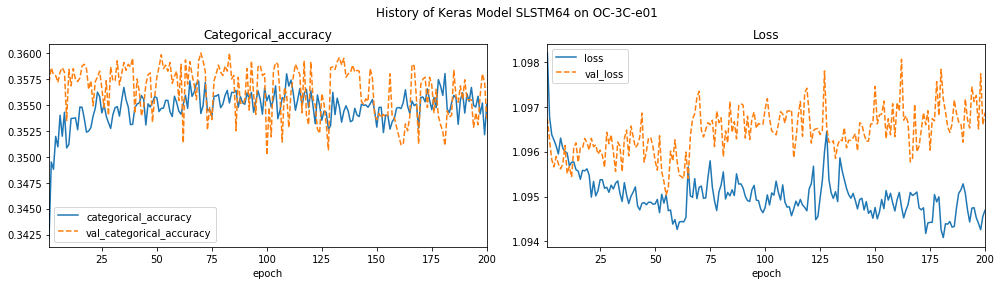

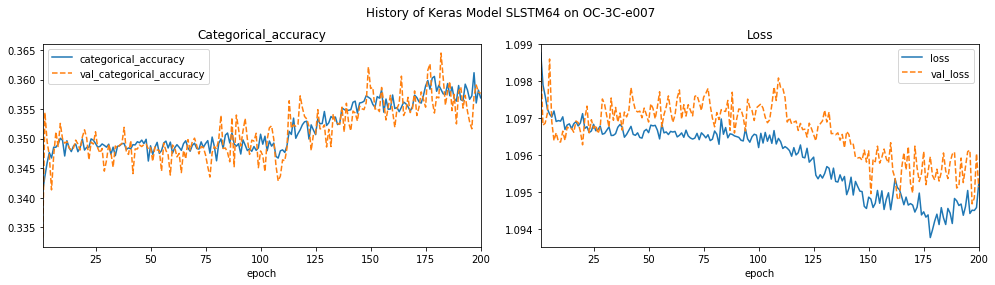

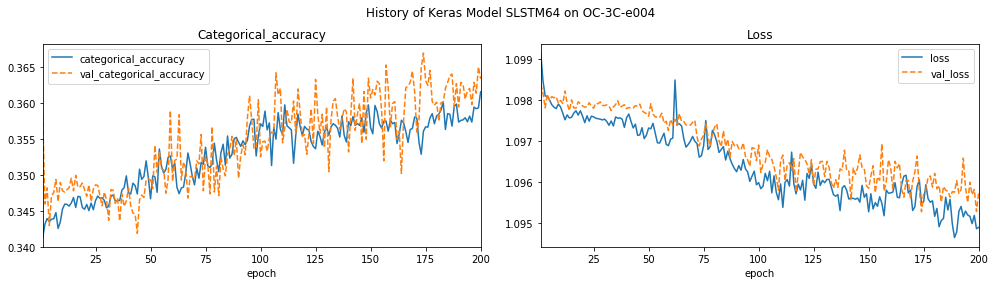

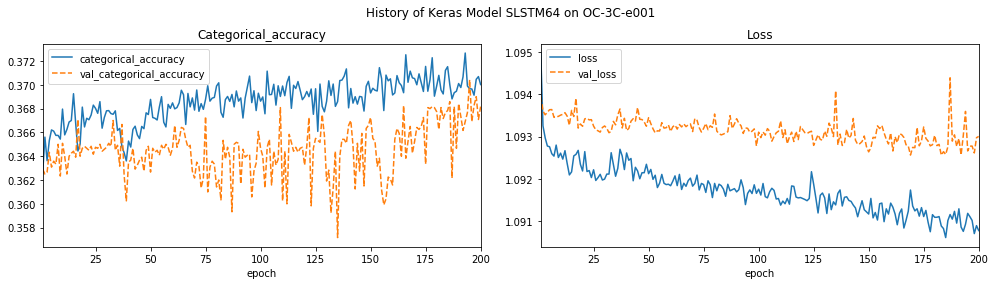

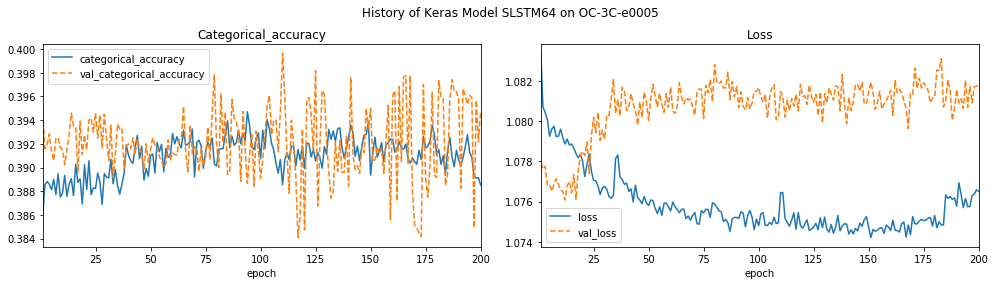

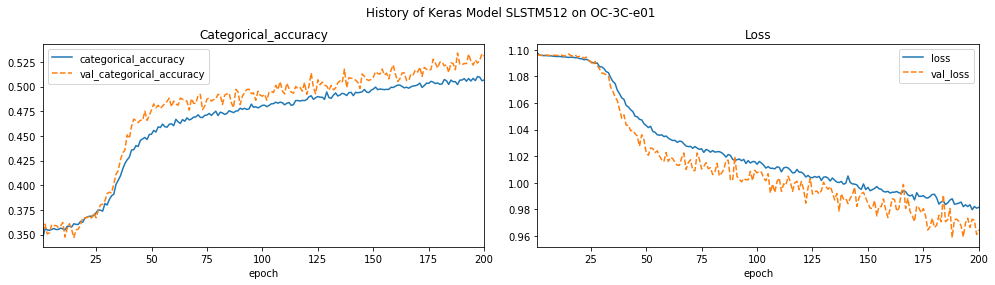

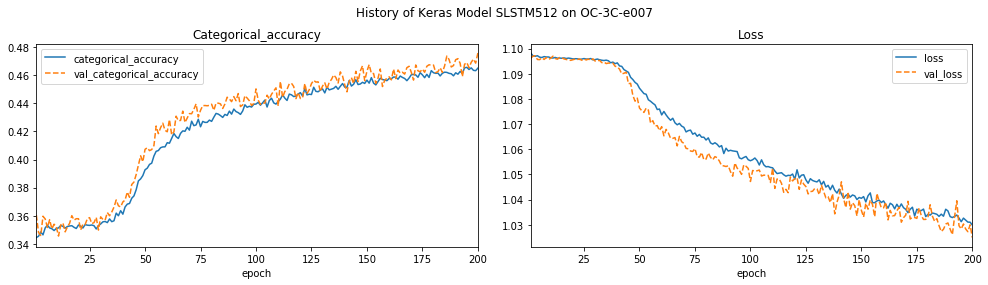

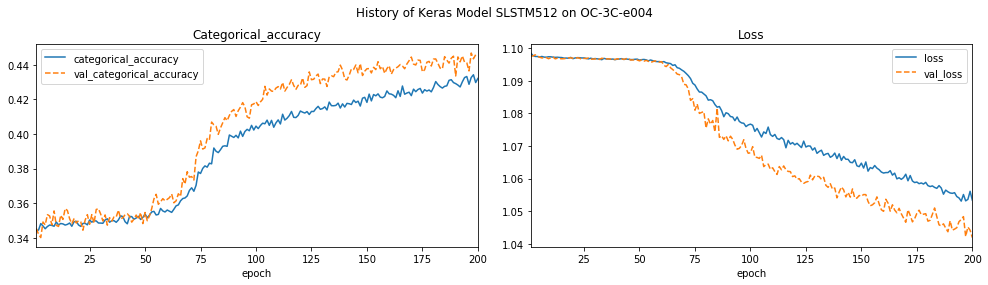

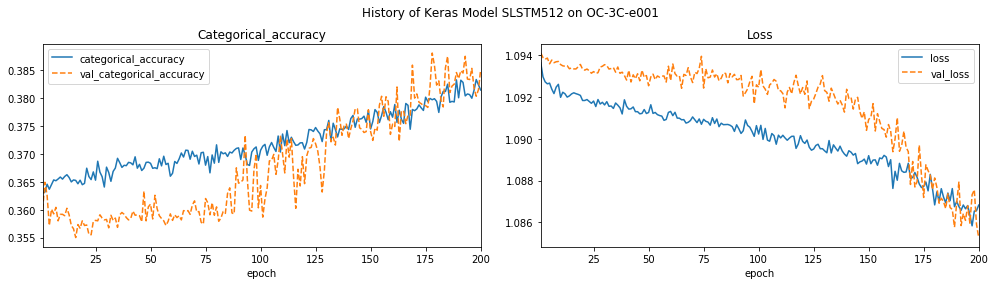

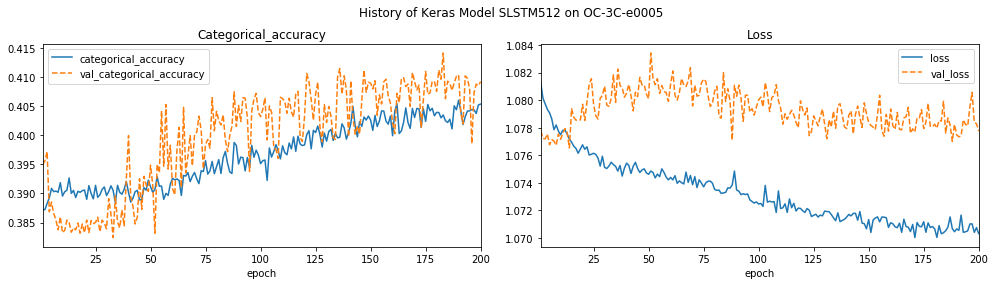

time: 13.2 s


In [75]:
plotter.plot_history(evaluator._temp_pipelines['OC-3C-e01']['SLSTM_bs64'][0].steps[-1][1].history, store=True, name='SLSTM64 on OC-3C-e01')
plotter.plot_history(evaluator._temp_pipelines['OC-3C-e007']['SLSTM_bs64'][0].steps[-1][1].history, store=True, name='SLSTM64 on OC-3C-e007')
plotter.plot_history(evaluator._temp_pipelines['OC-3C-e004']['SLSTM_bs64'][0].steps[-1][1].history, store=True, name='SLSTM64 on OC-3C-e004')
plotter.plot_history(evaluator._temp_pipelines['OC-3C-e001']['SLSTM_bs64'][0].steps[-1][1].history, store=True, name='SLSTM64 on OC-3C-e001')
plotter.plot_history(evaluator._temp_pipelines['OC-3C-e0005']['SLSTM_bs64'][0].steps[-1][1].history, store=True, name='SLSTM64 on OC-3C-e0005')

plotter.plot_history(evaluator._temp_pipelines['OC-3C-e01']['SLSTM_bs512'][0].steps[-1][1].history, store=True, name='SLSTM512 on OC-3C-e01')
plotter.plot_history(evaluator._temp_pipelines['OC-3C-e007']['SLSTM_bs512'][0].steps[-1][1].history, store=True, name='SLSTM512 on OC-3C-e007')
plotter.plot_history(evaluator._temp_pipelines['OC-3C-e004']['SLSTM_bs512'][0].steps[-1][1].history, store=True, name='SLSTM512 on OC-3C-e004')
plotter.plot_history(evaluator._temp_pipelines['OC-3C-e001']['SLSTM_bs512'][0].steps[-1][1].history, store=True, name='SLSTM512 on OC-3C-e001')
plotter.plot_history(evaluator._temp_pipelines['OC-3C-e0005']['SLSTM_bs512'][0].steps[-1][1].history, store=True, name='SLSTM512 on OC-3C-e0005')